This notebook runs OceTrac on a subset of OISST data.

Reviewing the notebook the subset isn't very effective because of the way that OISST is chunked, with the full globe as being a part of every chunk.  For that reason effort on this notebook stopped and the OceTrac_subset_MUR notebook was purused.

In [1]:
import s3fs
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from dask.distributed import Client

import ocetrac

# Set up Cluster

In [2]:
client = Client()

In [3]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:58283,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://192.168.1.10:58295,Total threads: 2
Dashboard: http://192.168.1.10:58296/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:58287,


# Load Data

## OISST

In [2]:
endpoint_url = 'https://ncsa.osn.xsede.org'
fs_osn = s3fs.S3FileSystem(anon=True, client_kwargs={'endpoint_url': endpoint_url},) 

path = "Pangeo/pangeo-forge/noaa_oisst/v2.1-avhrr.zarr"
ds = xr.open_zarr(fs_osn.get_mapper(path), consolidated=True)
oisst = ds.sst.isel(zlev=0).drop('zlev')

In [3]:
oisst

<xarray.DataArray 'sst' (time: 14532, lat: 720, lon: 1440)>
dask.array<getitem, shape=(14532, 720, 1440), dtype=float32, chunksize=(20, 720, 1440), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
  * time     (time) datetime64[ns] 1981-09-01T12:00:00 ... 2021-06-14T12:00:00
Attributes:
    long_name:  Daily sea surface temperature
    units:      Celsius
    valid_max:  4500
    valid_min:  -300

### Data Exploration

In [ ]:
oisst_max = oisst.sel(time=slice('1981')).max()  # 34.82
oisst_min = oisst.sel(time=slice('1981')).min()  # -1.8

In [ ]:
oisst_max.compute()

In [ ]:
oisst_min.compute()

# Subset

In [10]:
oisst_subset = oisst.sel(time=slice('2003-01', '2003-12'), lat=slice(30, 40), lon=slice(120, 160))

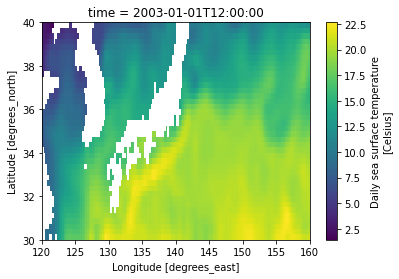

In [11]:
oisst_subset.isel(time=0).plot()

In [ ]:
# oisst_subset = oisst_subset.chunk({'lat': 25, 'lon': 25, 'time': 2})
# ^ hot_water calc freaks out "dimension time ... consists of multiple chunks, but is 
# also a core dimension" if you rechunk like this

### Create Masks

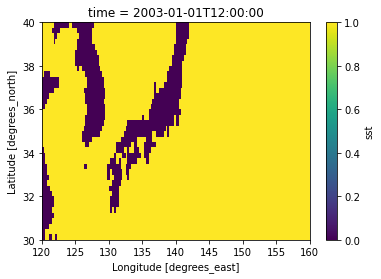

In [12]:
mask_ocean = 1 * np.ones(oisst_subset.shape[1:]) * np.isfinite(oisst_subset.isel(time=0))
mask_land = 0 * np.ones(oisst_subset.shape[1:]) * np.isnan(oisst_subset.isel(time=0))
mask = mask_ocean + mask_land
mask = mask.chunk({'lat': 25, 'lon': 25})
mask.plot()

# Preprocess

Follows [Ocetrac CMIP6 example](https://ocetrac.readthedocs.io/en/latest/examples/cmip6.html)

In [13]:
%%time
climatology = oisst_subset.groupby(oisst_subset.time.dt.month).mean()
anomaly = oisst_subset.groupby(oisst_subset.time.dt.month) - climatology

anomaly.load()
# 3 years of data (clim + anom calc): 5min 6s total time (25x25x2 chunks)
# 3 years of data (clim + anom calc): 38.2s (default chunks) *gasp*
# 1 year of data (clim + anom calc): _____ (default chunks, no dask)
# 1 year of data (clim + anom calc): ~1 min wall time (default chunks)
# 1 year of data (clim + anom calc): 2min 21s wall time (25x25x2 chunks)

CPU times: user 3.85 s, sys: 804 ms, total: 4.65 s
Wall time: 1min 22s


<xarray.DataArray 'sst' (time: 365, lat: 40, lon: 160)>
array([[[        nan,         nan,  1.0283861 , ...,  0.3425789 ,
          0.54031944,  0.845808  ],
        [        nan,         nan,  1.038064  , ..., -0.19161224,
         -0.03032303,  0.21645355],
        [        nan,         nan,         nan, ..., -0.2641945 ,
         -0.0993557 ,  0.03193474],
        ...,
        [ 1.6200001 ,  1.4987097 ,  1.3341936 , ...,  2.4448395 ,
          2.605483  ,  2.5632248 ],
        [ 1.5951612 ,  1.5619355 ,  1.3845162 , ...,  1.6909676 ,
          1.8280649 ,  1.8525801 ],
        [ 1.6332256 ,  1.7009677 ,  1.6064516 , ...,  0.96580505,
          1.0483866 ,  1.0980644 ]],

       [[        nan,         nan,  0.9583864 , ...,  0.19257927,
          0.29031944,  0.53580856],
        [        nan,         nan,  0.9780636 , ..., -0.19161224,
         -0.14032173,  0.08645248],
        [        nan,         nan,         nan, ..., -0.24419403,
         -0.11935616, -0.00806427],
...
        [-2.2454844 , -2.1309676 , -2.0738707 , ..., -1.0474195 ,
         -1.249999  , -1.0945158 ],
        [-2.2022586 , -2.1929026 , -2.1248388 , ..., -0.89129066,
         -0.895483  , -0.74612904],
        [-2.1267743 , -2.1848383 , -2.1335478 , ..., -0.8022585 ,
         -0.6161289 , -0.4480648 ]],

       [[        nan,         nan, -2.1158066 , ..., -1.2483864 ,
         -1.2280655 , -1.2945175 ],
        [        nan,         nan, -2.1270962 , ..., -1.2858067 ,
         -1.2735481 , -1.2309685 ],
        [        nan,         nan,         nan, ..., -1.3035469 ,
         -1.293869  , -1.2254848 ],
        ...,
        [-2.2654843 , -2.1009674 , -1.9538708 , ..., -1.4274197 ,
         -1.5299988 , -1.2745152 ],
        [-2.3022585 , -2.2229028 , -2.0748386 , ..., -1.32129   ,
         -1.2054834 , -0.8861294 ],
        [-2.2867742 , -2.2948384 , -2.163548  , ..., -1.2622585 ,
         -0.93612957, -0.5680647 ]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 30.12 30.38 30.62 30.88 ... 39.12 39.38 39.62 39.88
  * lon      (lon) float32 120.1 120.4 120.6 120.9 ... 159.1 159.4 159.6 159.9
  * time     (time) datetime64[ns] 2003-01-01T12:00:00 ... 2003-12-31T12:00:00
    month    (time) int64 1 1 1 1 1 1 1 1 1 1 ... 12 12 12 12 12 12 12 12 12 12

In [14]:
%%time
percentile = .9
# .chunk(dict(time=-1)) fixes the 0 dim parallel error
oisst_subset = oisst_subset.chunk(dict(time=-1))
threshold = oisst_subset.groupby(oisst_subset.time.dt.month).quantile(percentile, 
                                                                      dim='time', 
                                                                      keep_attrs=True, 
                                                                      skipna=True,
                                                                     )

hot_water = anomaly.groupby(oisst_subset.time.dt.month).where(
    oisst_subset.groupby(oisst_subset.time.dt.month)>threshold
)

hot_water.load()

# 1 year of data (thresh + hot water calc): 1 m 37s wall time (default chunks)

CPU times: user 5.64 s, sys: 1.07 s, total: 6.71 s
Wall time: 1min 37s


<xarray.DataArray 'sst' (time: 365, lat: 40, lon: 160)>
array([[[       nan,        nan, 1.0283861 , ...,        nan,
                nan, 0.845808  ],
        [       nan,        nan, 1.038064  , ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [1.6200001 , 1.4987097 , 1.3341936 , ..., 2.4448395 ,
         2.605483  , 2.5632248 ],
        [1.5951612 , 1.5619355 , 1.3845162 , ..., 1.6909676 ,
         1.8280649 , 1.8525801 ],
        [1.6332256 , 1.7009677 , 1.6064516 , ..., 0.96580505,
         1.0483866 , 1.0980644 ]],

       [[       nan,        nan, 0.9583864 , ...,        nan,
                nan,        nan],
        [       nan,        nan, 0.9780636 , ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]], dtype=float32)
Coordinates:
  * time      (time) datetime64[ns] 2003-01-01T12:00:00 ... 2003-12-31T12:00:00
  * lat       (lat) float32 30.12 30.38 30.62 30.88 ... 39.12 39.38 39.62 39.88
  * lon       (lon) float32 120.1 120.4 120.6 120.9 ... 159.1 159.4 159.6 159.9
    month     (time) int64 1 1 1 1 1 1 1 1 1 1 ... 12 12 12 12 12 12 12 12 12 12
    quantile  float64 0.9

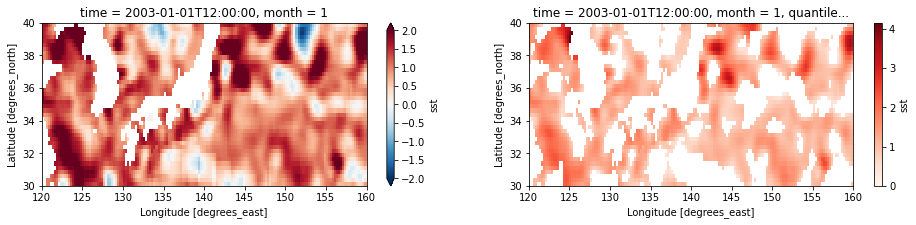

In [15]:
# Visualize
plt.figure(figsize=(16,3))

ax1 = plt.subplot(121);anomaly.isel(time=0).plot(cmap='RdBu_r', vmin=-2, vmax=2, extend='both')
# mask.where(mask==0).plot.contourf(colors='k', add_colorbar=False); ax1.set_aspect('equal');

ax2 = plt.subplot(122); hot_water.isel(time=0).plot(cmap='Reds', vmin=0);
# mask.where(mask==0).plot.contourf(colors='k', add_colorbar=False); ax2.set_aspect('equal');

## Run Ocetrac

In [16]:
hot_water = hot_water.rename({'lon':'x', 'lat':'y'})

In [17]:
%%time
Tracker = ocetrac.Tracker(hot_water, mask, radius=2, min_size_quartile=0.75, timedim = 'time', xdim = 'x', ydim='y', positive=True)
blobs = Tracker.track()

# 

/Users/rwegener/.pyenv/versions/miniconda3-4.7.12/envs/ocetrac/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 2.81 GiB -- Worker memory limit: 4.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 2.84 GiB -- Worker memory limit: 4.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim fo

KilledWorker: ("('vectorize_get_labels-vectorize_get_labels_0-transpose-42696ff2cc8600e847437a31d665634a', 0, 0, 2, 0, 0)", <WorkerState 'tcp://10.104.161.124:50082', name: 3, memory: 0, processing: 4>)

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 3.19 GiB -- Worker memory limit: 4.00 GiB
distributed.worker - WARNING - Worker is at 90% memory usage. Pausing worker.  Process memory: 3.60 GiB -- Worker memory limit: 4.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 3.60 GiB -- Worker memory limit: 4.00 GiB
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
tornado.application - ERROR - Uncaught exception GET /workers/ws (127.0.0.1)
HTTPServerRequest(protocol='http', host='127.0.0.1:8787', method='GET', uri='/workers/ws',